# Wine Quality Prediction using linear regression (minimal)

Using the dataset: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [1]:
# Uncomment and run the commands below if imports fail
# !conda install numpy pytorch torchvision cpuonly -c pytorch -y
# !pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

In [2]:
# Imports
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

<IPython.core.display.Javascript object>

In [3]:
# Hyperparameters
batch_size=64
learning_rate=5e-7


input_size=11
output_size=1

## Dataset & Data loaders

In [4]:
# Download the data
dataframe = pd.read_csv("../input/wine-quality/winequality-red.csv",sep=";")
dataframe.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('quality', axis=1).values
targets = dataframe[['quality']].values
inputs.shape, targets.shape

((1599, 11), (1599, 1))

In [6]:
# Convert to PyTorch dataset
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))
train_ds, val_ds = random_split(dataset, [1200, 399])

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)

## Model

In [7]:
class Winequality(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = Winequality()

## Training

In [8]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [9]:
result = evaluate(model, val_loader)
result

{'val_loss': 64.13894653320312}

In [10]:
history = fit(100, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 59.2059
Epoch [1], val_loss: 54.8972
Epoch [2], val_loss: 51.1017
Epoch [3], val_loss: 47.7585
Epoch [4], val_loss: 44.8499
Epoch [5], val_loss: 42.2902
Epoch [6], val_loss: 40.0397
Epoch [7], val_loss: 38.0642
Epoch [8], val_loss: 36.3344
Epoch [9], val_loss: 34.8116
Epoch [10], val_loss: 33.4617
Epoch [11], val_loss: 32.2894
Epoch [12], val_loss: 31.2413
Epoch [13], val_loss: 30.3079
Epoch [14], val_loss: 29.4934
Epoch [15], val_loss: 28.7619
Epoch [16], val_loss: 28.1122
Epoch [17], val_loss: 27.5365
Epoch [18], val_loss: 27.0209
Epoch [19], val_loss: 26.5567
Epoch [20], val_loss: 26.1375
Epoch [21], val_loss: 25.7615
Epoch [22], val_loss: 25.4187
Epoch [23], val_loss: 25.1120
Epoch [24], val_loss: 24.8322
Epoch [25], val_loss: 24.5764
Epoch [26], val_loss: 24.3409
Epoch [27], val_loss: 24.1285
Epoch [28], val_loss: 23.9253
Epoch [29], val_loss: 23.7425
Epoch [30], val_loss: 23.5739
Epoch [31], val_loss: 23.4161
Epoch [32], val_loss: 23.2666
Epoch [33], val_loss

In [16]:
history = fit(500, learning_rate, model, train_loader, val_loader)

Epoch [0], val_loss: 5.5160
Epoch [1], val_loss: 5.5011
Epoch [2], val_loss: 5.4857
Epoch [3], val_loss: 5.4708
Epoch [4], val_loss: 5.4562
Epoch [5], val_loss: 5.4412
Epoch [6], val_loss: 5.4264
Epoch [7], val_loss: 5.4118
Epoch [8], val_loss: 5.3971
Epoch [9], val_loss: 5.3826
Epoch [10], val_loss: 5.3680
Epoch [11], val_loss: 5.3534
Epoch [12], val_loss: 5.3389
Epoch [13], val_loss: 5.3244
Epoch [14], val_loss: 5.3099
Epoch [15], val_loss: 5.2957
Epoch [16], val_loss: 5.2815
Epoch [17], val_loss: 5.2672
Epoch [18], val_loss: 5.2529
Epoch [19], val_loss: 5.2388
Epoch [20], val_loss: 5.2245
Epoch [21], val_loss: 5.2104
Epoch [22], val_loss: 5.1964
Epoch [23], val_loss: 5.1823
Epoch [24], val_loss: 5.1683
Epoch [25], val_loss: 5.1544
Epoch [26], val_loss: 5.1405
Epoch [27], val_loss: 5.1268
Epoch [28], val_loss: 5.1131
Epoch [29], val_loss: 5.0993
Epoch [30], val_loss: 5.0856
Epoch [31], val_loss: 5.0722
Epoch [32], val_loss: 5.0585
Epoch [33], val_loss: 5.0448
Epoch [34], val_loss: 5.

Epoch [280], val_loss: 2.7416
Epoch [281], val_loss: 2.7356
Epoch [282], val_loss: 2.7296
Epoch [283], val_loss: 2.7236
Epoch [284], val_loss: 2.7176
Epoch [285], val_loss: 2.7116
Epoch [286], val_loss: 2.7057
Epoch [287], val_loss: 2.6997
Epoch [288], val_loss: 2.6937
Epoch [289], val_loss: 2.6878
Epoch [290], val_loss: 2.6819
Epoch [291], val_loss: 2.6760
Epoch [292], val_loss: 2.6700
Epoch [293], val_loss: 2.6640
Epoch [294], val_loss: 2.6582
Epoch [295], val_loss: 2.6523
Epoch [296], val_loss: 2.6465
Epoch [297], val_loss: 2.6407
Epoch [298], val_loss: 2.6350
Epoch [299], val_loss: 2.6291
Epoch [300], val_loss: 2.6234
Epoch [301], val_loss: 2.6177
Epoch [302], val_loss: 2.6119
Epoch [303], val_loss: 2.6063
Epoch [304], val_loss: 2.6006
Epoch [305], val_loss: 2.5949
Epoch [306], val_loss: 2.5893
Epoch [307], val_loss: 2.5837
Epoch [308], val_loss: 2.5781
Epoch [309], val_loss: 2.5726
Epoch [310], val_loss: 2.5670
Epoch [311], val_loss: 2.5615
Epoch [312], val_loss: 2.5560
Epoch [313

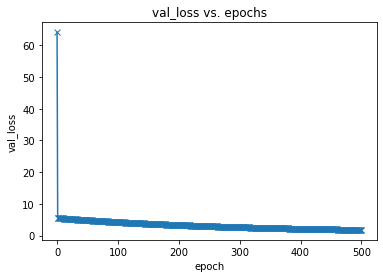

In [17]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

## Prediction

In [18]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [19]:
x, target = val_ds[12]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 7.2000,  0.5700,  0.0600,  1.6000,  0.0760,  9.0000, 27.0000,  0.9972,
         3.3600,  0.7000,  9.6000])
Target:  6.0
Prediction: 4.250435829162598


In [20]:
x, target = val_ds[47]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([ 7.0000,  0.5100,  0.0900,  2.1000,  0.0620,  4.0000,  9.0000,  0.9958,
         3.3500,  0.5400, 10.5000])
Target:  5.0
Prediction: 4.125272750854492


## Save and upload

In [21]:
torch.save(model.state_dict(), 'winequality.pth')

In [22]:
jovian.commit(project='winequality', environment=None, outputs=['winequality'])
jovian.commit(project='winequality', environment=None, outputs=['winequality']) # Kaggle commit fails sometimes, so try again..

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/winequality


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/sagnik2019/winequality


<IPython.core.display.Javascript object>